In [1]:
! which python

/Users/no_lineal/opt/anaconda3/envs/grid38/bin/python


In [2]:
import numpy as np
import pickle

from scipy.ndimage import maximum_filter

from tqdm import tqdm

import os

# viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

In [3]:
""" 

    where am i?

"""

PATH = os.getcwd()
data_path = PATH.replace( '01_square_156', '' ) + 'data/01_square/01_square_1000000_156_129/'

print( f'PATH: { PATH }' )
print( f'data_path: { data_path }' )

PATH: /Users/no_lineal/Documents/draft_code/grid_metrics/01_square_156
data_path: /Users/no_lineal/Documents/draft_code/grid_metrics/data/01_square/01_square_1000000_156_129/


In [4]:
""" 

    load correlation matrix

"""

ratemap_mat = np.load( data_path + 'grid_scores/ratemap.npy' )

sac_max_mat = np.load( data_path + 'grid_scores/sac/max/sac.npy' )

print('')
print( f'ratemap_mat: { ratemap_mat.shape }' )
print('')
print( f'sac_max_mat: { sac_max_mat.shape }' )
print('')


ratemap_mat: (512, 32, 32)

sac_max_mat: (512, 63, 63)



In [5]:
""" 

    peak filtering

"""

def peak_filter( sac, hc_centre=True, footprint=( 5, 5 ) ):

    if hc_centre:

        centre = sac.shape[0] // 2
        global_max_pos = ( centre, centre )

    else:

        global_max_pos = np.unravel_index( np.argmax( sac ), sac.shape )

    local_max_pos = maximum_filter( sac, footprint=np.ones( footprint ), mode='wrap' )
    dists = [ np.linalg.norm( np.array( global_max_pos ) - np.array( pos ) ) for pos in np.argwhere( local_max_pos == sac ) ]

    local_max_pos = np.argwhere( local_max_pos == sac )

    return global_max_pos, local_max_pos, dists

# get distances
save = True

global_mat = []
local_mat = []
dists_mat = []

for corr in tqdm( sac_max_mat ):

    global_max_pos, local_max_pos, dists = peak_filter( corr )

    global_mat.append( global_max_pos )
    local_mat.append( local_max_pos )
    dists_mat.append( dists )

median_mat = [ np.sort(np.array( x )) for x in dists_mat ]
median_mat = [ np.median( x[ np.nonzero(x)[0] ][:6] ) for x in median_mat ]

if save:

    with open( data_path + 'grid_scores/sac/max/global_mat.pkl', 'wb' ) as f:
        pickle.dump( global_mat, f )

    with open( data_path + 'grid_scores/sac/max/local_mat.pkl', 'wb' ) as f:
        pickle.dump( local_mat, f )

    with open( data_path + 'grid_scores/sac/max/dists_mat.pkl', 'wb' ) as f:
        pickle.dump( dists_mat, f )

    with open( data_path + 'grid_scores/sac/max/median_mat.pkl', 'wb' ) as f:
        pickle.dump( median_mat, f )

100%|██████████| 512/512 [00:00<00:00, 1489.26it/s]


sample idx: [406 250 465 389 508 172 417 402 127  86]


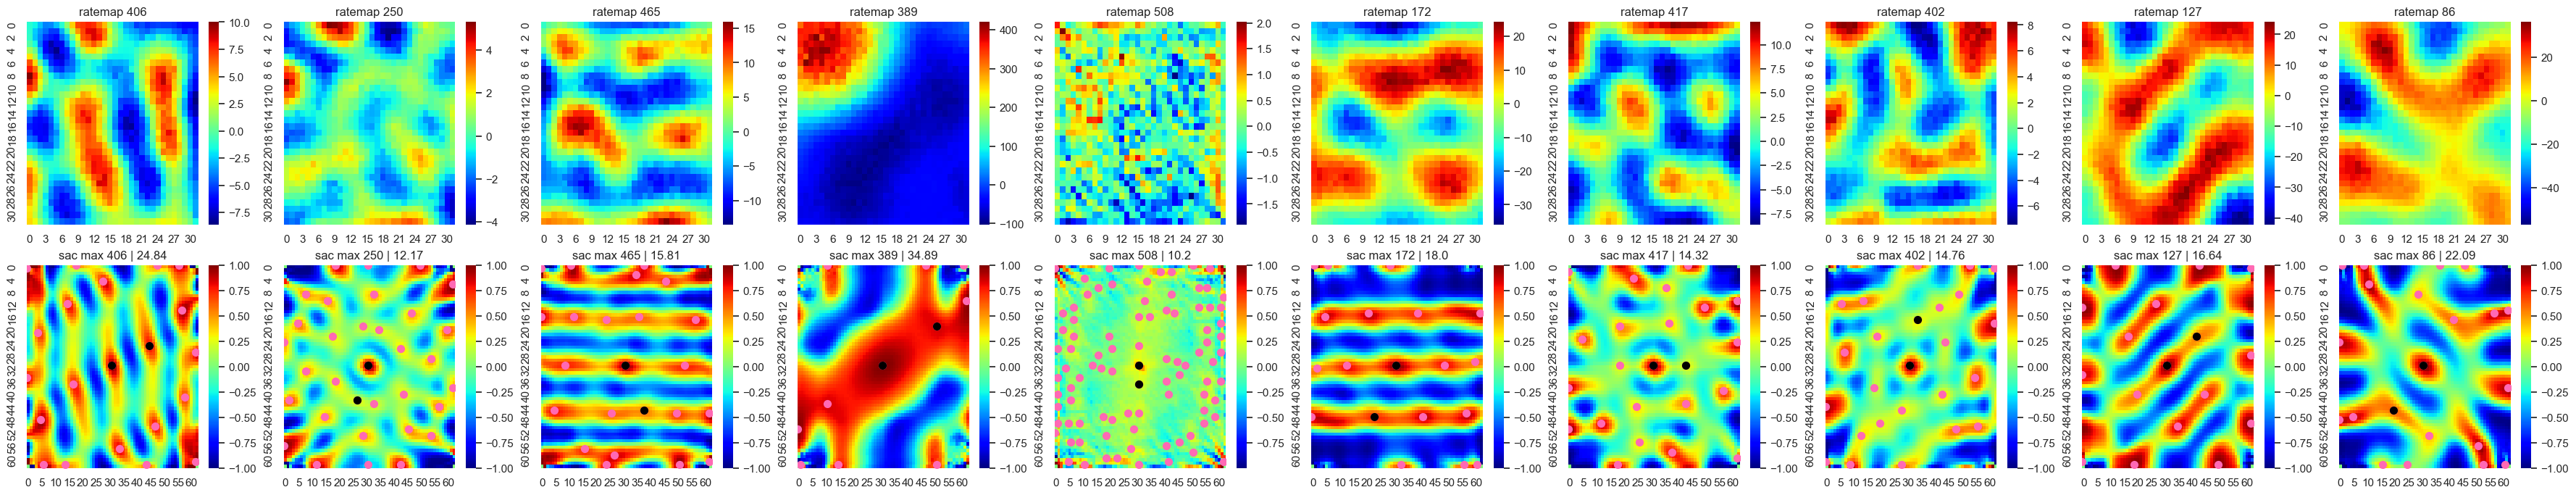

In [6]:
""" 

    viz distances

"""

k = 10

sample_idx = np.random.randint( 0, len( ratemap_mat ), k )
print( f'sample idx: { sample_idx }' )

fig, axs = plt.subplots( 2, k, figsize=( 45, 8 ) )

for i, r in enumerate( ratemap_mat[ sample_idx ] ):

    sns.heatmap( r, ax=axs[ 0, i ], cmap='jet' )
    axs[ 0, i ].set_title( f'ratemap { sample_idx[i] }' )

    ad = dists_mat[ sample_idx[i] ]
    al = local_mat[ sample_idx[i] ]

    ad = np.argsort( ad )[1]
    al = list(al)[ ad ]

    sns.heatmap( sac_max_mat[ sample_idx[i] ], ax=axs[ 1, i ], cmap='jet' )

    axs[ 1, i ].scatter( local_mat[ sample_idx[i] ][:, 1], local_mat[ sample_idx[i] ][:, 0], c='hotpink', s=50)
    axs[ 1, i ].scatter( global_mat[ sample_idx[i] ][1], global_mat[ sample_idx[i] ][0], c='black', s=50 )
    axs[ 1, i ].scatter( al[1], al[0], c='black', s=50 )

    axs[ 1, i ].set_title( f'sac max { sample_idx[i] } | { round( median_mat[ sample_idx[i] ], 2 ) }' )

plt.show()